#### Imports

In [1]:
import utilities.logging as Logger
import integration.files as Files
import evaluation.general as GenEval
import evaluation.iv as IVEval
import utilities.macros as Macros
import plotting.plot as Plot
import utilities.constants as Constants
import os

#### Init

In [2]:
bib = Files.DataCollection()

Logger.setup(bib)
Logger.set_level(Logger.INFO)
Files.setup(bib, "Test", rf"/home/{os.getlogin()}/Downloads")
GenEval.setup(bib)
IVEval.setup(bib)

(...) Logger.setup()
(...) Logger.set_level(lvl=Level.INFO)
(...) Files.setup(name=Test, root_dir=/home/dacap/Downloads)
(Test) GenEval.setup()
(Test) IVEval.setup()


#### Config

In [94]:
bib.data.file_name = "2023-11-04_G0_antenna.hdf5"
bib.params.volt_amp = (10000.0, 1000.0)
bib.params.evalTemperature = False
bib.params.linearizeYAxis = True
bib.params.normalizeXAxis = True
bib.params.smoothData = True
bib.iv_params.bins = 1200

#### Selection

In [95]:
GenEval.loadMeasurements(bib)
GenEval.showLoadedMeasurements(bib)
GenEval.select_measurement(bib, 1)

IVEval.select_edge(bib, 1, "up")

(Test) GenEval.loadMeasurements()
(Test)   Measurement header format unknown: critical field - list index out of range
(Test)   Measurement header format unknown: frequency_at_-20dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_-25dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_19.3GHz - list index out of range
(Test)   Measurement header format unknown: frequency_at_7.8GHz - list index out of range
(Test) GenEval.showLoadedMeasurements()
(Test)   [1] var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) GenEval.select_measurement(index=1)
(Test)   Selected: var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test)       with: 32 entries
(Test) IVEval.select_edge(num=1,dir=up)


In [96]:
Macros.load(bib, 1)
Macros.eval(bib, "adwin")

(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


In [97]:
Macros.bulk_eval(bib)

(Test)   Evaluating Set: 32/32 (97%) (id: nu=-1.0dBm)(Test) 
Finished evaluating all sets
(Test)   Linearizing Y-axis values from dBm to V
(Test)   Smoothing data with moving average


(1200, 1191)


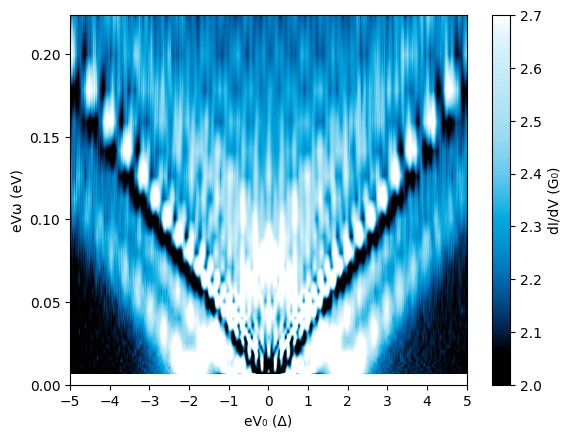

In [98]:
from plotting.plot import StyleKeys as SK

VVI_style = {
    SK.X_LABEL: "eV₀ (Δ)",
    SK.Y_LABEL: "eVω (eV)",
    SK.Z_LABEL: "dI/dV (G₀)",
    SK.SCALE: (1, 1, 1),
    SK.X_LIM: (-5, 5),
    # SK.Y_LIM: (0, 0.2),
    SK.CMAP: "seeblau",
    SK.CBAR: True,
    SK.X_TICKS: (-5, 5, 1),
    SK.Y_TICKS: (0, 0.2, 0.05),
    SK.ASPECT: "auto",
    # SK.INTERPOL: "bilinear",
    SK.FLIP_VERTICAL: True,
}

Plot.map(bib, ["dVXC"], [VVI_style])

(251, 1179)


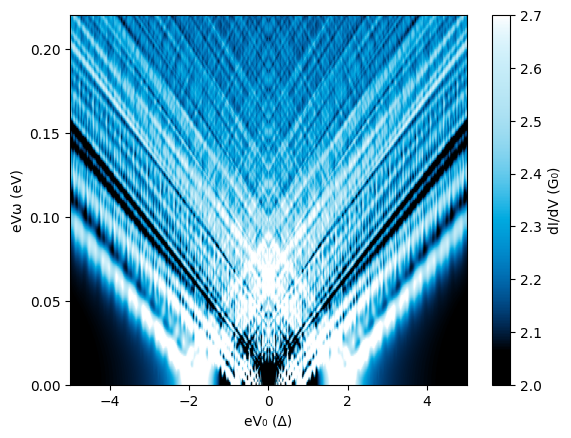

In [99]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from plotting.corporate_design_colors_v4 import cmap

# open jld2 file
file = "/home/dacap/Documents/p5control-bluefors-evaluation/simulation/data/TG-IV.jld2"

ts = [0.80, 0.62, 0.33, 0.25, 0.01]

map = np.zeros((251, 1179), dtype=np.float64)
x = None
y = None
for t in ts:
    with h5py.File(file, "r") as f:
        dir = f["τ=" + str(t)]
        data = np.array(dir["dIdV"])
        map += data

map = np.flipud(map)
x = np.linspace(-6.1, 6.1, map.shape[1])
y = np.linspace(0, 0.24, map.shape[0])  # np.linspace(0, 1, map.shape[0])

print(map.shape)

plt.imshow(
    map,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=(2, 2.7),
)
plt.colorbar(label="dI/dV (G₀)")
plt.xlim(-5, 5)
plt.ylim(0, 0.22)
plt.xlabel("eV₀ (Δ)")
plt.ylabel("eVω (eV)")
plt.yticks(np.arange(0, 0.215, 0.05))

plt.show()

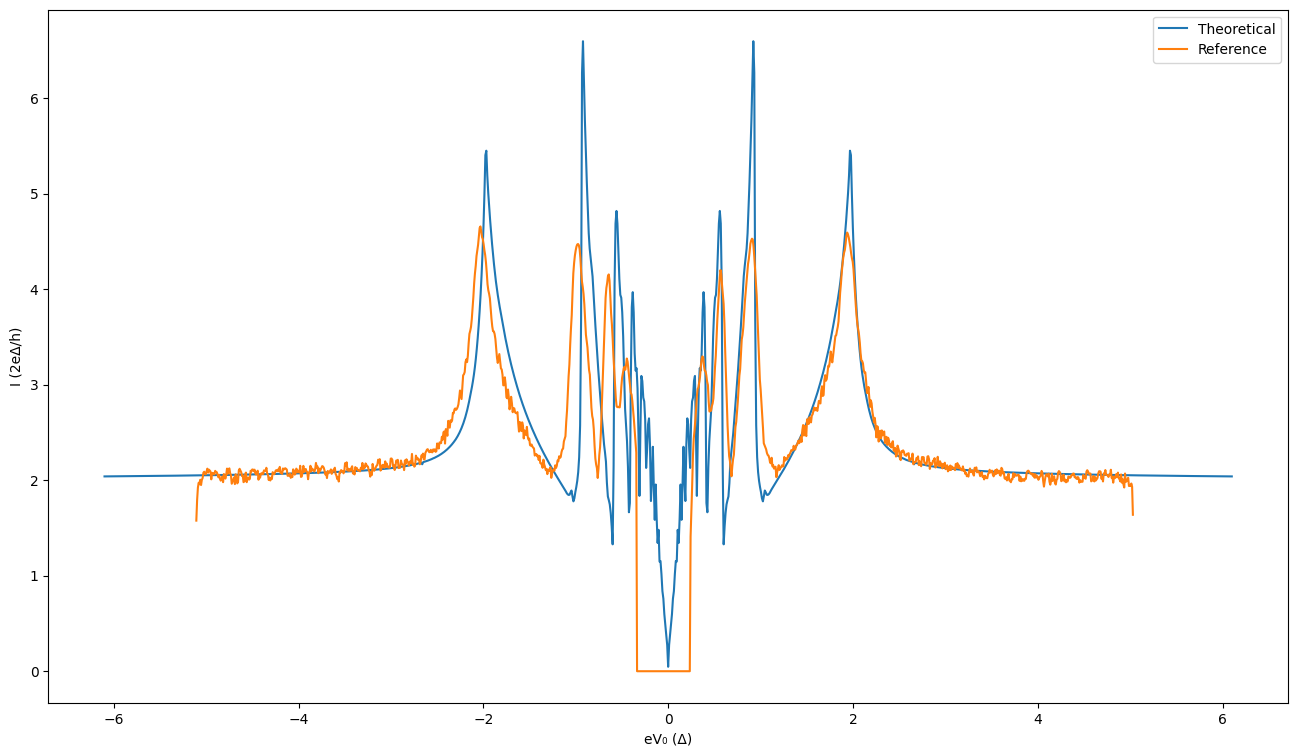

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from utilities.math import moving_average

evolution = 0

plt.figure(figsize=(16, 9))

theo = np.flipud(map)
x_theo = x
y_theo = theo[evolution + 1, :]
plt.plot(x, y_theo, label="Theoretical")


# Macros.load(bib, 1)
# Macros.eval(bib, "adwin")

x_exp = bib.result.maps["dVXC"].x_axis.values
if bib.params.smoothData:
    x_exp = x_exp[0 : len(x_exp) - 9]
y_exp = bib.result.maps["dVXC"].values[evolution, :]
plt.plot(x_exp, y_exp, label="Reference")

# Macros.load(bib, evolution)
# Macros.eval(bib, "adwin")

# x2 = bib.evaluation.persistent_sets["norm"].curves["voltage-bin"]
# y2 = bib.evaluation.cached_sets["adwin"].curves["current-voltage"] * 1e6
# plt.plot(x2, y2, label="Irradiated")

plt.xlabel("eV₀ (Δ)")
plt.ylabel("I (2eΔ/h)")
# plt.xlim(-6, 6)
# plt.ylim(-15.5, 15.5)
plt.legend()

# plt.figure()

# dx1 = np.gradient(x1)
# dy1 = np.gradient(y1)
# plt.plot(x1, dy1 / dx1, label="Reference")

# dx2 = np.gradient(x2)
# dy2 = np.gradient(y2)
# plt.plot(x2, dy2 / dx2, label="Irradiated")

# plt.xlabel("eV₀ (Δ)")
# plt.ylabel("dI/dV (G₀)")
# # plt.xlim(-6, 6)
# plt.legend(loc="upper left")

# plt.figure()

# dy1 = moving_average(dy1, 10)
# # plt.plot(dy1)
# dy1 = moving_average(dy1, 10)
# # plt.plot(dy1)
# dy1 = moving_average(dy1, 10)
# dy1 = moving_average(dy1, 10)
# plt.plot(dy1)


# y_labels = [
#     GenEval.MeasurementHeader.parse_number(l)[0]
#     for l in bib.params.available_measurement_entries_labels
# ]
# print(sorted(y_labels)[evolution])